<h1>The5Outliers - <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span>: why so many players pass through Geography or Countries to reach their target</h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import kurtosis
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go

from src.utils.HTMLParser import HTMLParser
from src.data.data_loader import *
from src.utils.helpers import *
from src.models.networks import *

parser = HTMLParser()
parser.load_pickle()

# 1. Data cleaning and loading

This part loads, cleans the data, and defines useful datasets for further analysis. 

- `read_articles()` loads a list of valid article names, that is without special characters and discardig any invalid articles, like non-wikispedia articles or with missing categories
- `parser.get_df_html_stats()` gathers wikispedia page statistics like number of links, link density, and structural information
- `read_categories()` sorts for each category of a same article its different levels of sub categories 
- `read_links()` gathers all the links outward of a page 
- `read_shortest_path_matrix()` reads the matrix of shortest paths possible between two articles 
- `read_unfinished_paths()` and `read_finished_paths()` load the original unfinished and finished paths and clean them
- `read_similartiy_matrix()` reads the matrix of semantic similarity between article names 
- `read_categories_matrix()` reads the matrix that describes the similarity between article's category levels and sub-levels

In [3]:
df_article_names = read_articles() 
df_html_stats = parser.get_df_html_stats()
df_categories = read_categories()
df_links = read_links()
df_shortest_path = read_shortest_path_matrix()
df_unfinished = read_unfinished_paths()
df_finished = read_finished_paths() 
df_sm = read_similartiy_matrix() 
df_scat = read_categories_matrix()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Test', 'Usa', 'The Rock', 'Georgia', 'The', 'Black ops 2', 'Sportacus', 'Adolph Hitler', 'Great', 'Netbook', 'Macedonia', 'Charlottes web', 'Christmas', ' Zebra', 'English', 'Podcast', 'Mustard', 'Kashmir', 'Long peper', 'Bogota', 'Rss', 'Rat', 'Pikachu', 'Western Australia', 'Fats'}
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24714 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of rows after filtering: 51199


# 2. Add features to articles and paths

## 2.1. Article features 
In and out degree of articles are added. 
- **In degree** of an article corresponds to the number of links on other pages targetting an article 
- **Out degree** of an article corresponds to the number of links towards other pages on this article

Some notes:
- Some articles have no articles leading to it 
- Some articles lead to no other articles
- Links do not consider duplicates inside the page (each link is considered to appear once, but this will be relaxed with HTML parsing)

In [4]:
df_article = pd.DataFrame(df_article_names).copy()

# Compute in-degree (number of times each article is a target link)
in_degree = df_links.groupby('linkTarget').size().reset_index(name="in_degree")
# Compute out-degree (link density: number of times each article is a source link)
out_degree = df_links.groupby('linkSource').size().reset_index(name="out_degree")

# Merge in-degree and out-degree with df_article_names
df_article = df_article.merge(in_degree, left_on='article', right_on='linkTarget', how='left')
df_article = df_article.merge(out_degree, left_on='article', right_on='linkSource', how='left')
df_article = df_article.drop(columns=['linkTarget', 'linkSource'])

# Fill NaN values with 0, assuming no links imply zero counts for those articles
df_article = df_article.fillna(0).astype({'in_degree': 'int', 'out_degree': 'int'})

# add the html stats to the articles
df_html_stats = df_html_stats.rename(columns={'article_name': 'article'})
df_article = pd.merge(df_article, df_html_stats, how='inner')

# add the category (level_1) to each articles
category_map = dict(zip(df_categories["article"], df_categories["level_1"]))
df_article["category"] = df_article["article"].map(category_map)

## 2.2. Path features 
New metrics are added to characterize the game paths. Specifically:

- **Path Length** which accounts for the total number of articles in a path

- **Back-Clicks** which indicates how many times the user revisited previous articles

- **Cosine Similarity** which measures the semantic similarity between the source and target articles

- **Shortest Path** which gives the length of the shortest path possible between the source and target articles

- **Categories Similarity** which  measure the category similarity between the categories of the source and target articles

In [5]:
# let's add some useful metrics to each paths dataframe: shortest path, semantic similarity
df_unfinished['cosine_similarity'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_unfinished['shortest_path'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_unfinished['path_length'] = df_unfinished['path'].apply(lambda x: x.count(';') + 1)
df_unfinished['back_clicks'] = df_unfinished['path'].apply(lambda x: x.count('<'))
df_unfinished['categories_similarity'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

df_finished['cosine_similarity'] = df_finished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_finished['shortest_path'] = df_finished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_finished['path_length'] = df_finished['path'].apply(lambda x: x.count(';') + 1)
df_finished['back_clicks'] = df_finished['path'].apply(lambda x: x.count('<'))
df_finished['categories_similarity'] = df_finished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

# 3. Core results

## 3.1. Article features

### 3.1.a. Distributions of words, links, and categories in articles

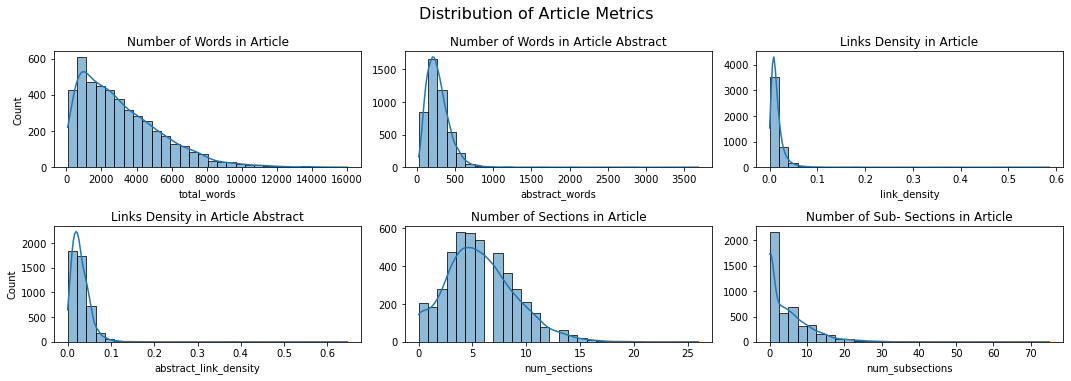

In [6]:
metrics = [
    ("total_words", "Number of Words in Article"),
    ("abstract_words", "Number of Words in Article Abstract"),
    ("link_density", "Links Density in Article"),
    ("abstract_link_density", "Links Density in Article Abstract"),
    ("num_sections", "Number of Sections in Article"),
    ("num_subsections", "Number of Sub- Sections in Article")
]

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Loop through metrics to create histograms
for i, (metric, title) in enumerate(metrics):
    row, col = divmod(i, 3)
    sn.histplot(df_article, x=metric, bins=30, kde=True, ax=ax[row, col])
    ax[row, col].set_title(title)
    if col == 1 or col == 2:
        ax[row, col].set_ylabel('')

plt.tight_layout()
plt.suptitle("Distribution of Article Metrics", y=1.05, fontsize=16)
plt.show()

Results : The data is right-skewed for most of metrics, indicating that while most articles adhere to certain standards of complexity and length, a small subset stands out as particularly detailed or interconnected.

### 3.1.b Articles Complexity

Which categories feature the most complex articles? To answer this question, let’s identify the most complex articles and the categories they belong to. We define complexity based on factors such as the number of words, links, and sections within each article.

In [7]:
#define palette for categories
df_article["category"]=df_article["article"].apply(lambda x: df_categories[df_categories["article"]==x]["level_1"].values[0] if len(df_categories[df_categories["article"]==x]["category"].values)>0 else "None")
categories = sorted(df_article["category"].unique())
palette_category = sn.color_palette("tab20", len(categories))
color_mapping = dict(zip(categories, palette_category))

def add_legend_category(fig, palette_category=palette_category, categories=categories, bbox_to_anchor=(1.15, 0.85)):

    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10) 
            for color in palette_category]
    labels = categories
    fig.legend(
        handles, 
        labels, 
        bbox_to_anchor=bbox_to_anchor, 
        title="Categories"
    )

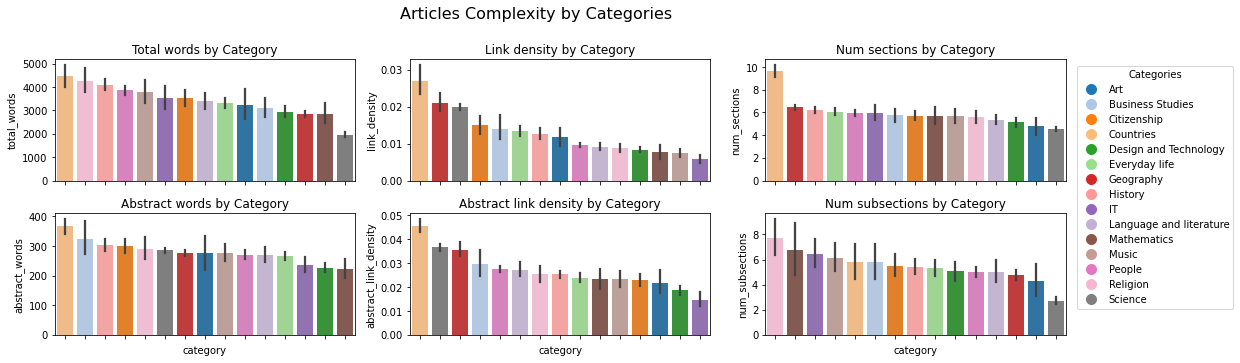

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Define the parameters for each subplot
metrics = [
    "total_words", "link_density", "num_sections",
    "abstract_words", "abstract_link_density", "num_subsections"
]

# Loop through metrics and plot
for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    order = df_article.groupby("category")[metric].mean().sort_values(ascending=False).reset_index()["category"]
    sn.barplot(
        x="category", 
        y=metric, 
        hue="category", 
        palette=color_mapping, 
        data=df_article, 
        ax=ax[row, col], 
        order=order
    )
    ax[row, col].set_title(f'{metric.replace("_", " ").capitalize()} by Category')
    ax[row, col].set_xticklabels([])
    if row == 0 :
        ax[row, col].set_xlabel('')

add_legend_category(fig)

plt.suptitle("Articles Complexity by Categories", y=1, fontsize=16)
plt.tight_layout()
plt.show()

Results : The category "Countries" stands out as a particularly complex topic, characterized by articles with the highest link density, the greatest number of category levels, and the longest abstract.

### 3.1.c Articles Popularity and Connectivity

Is there a correlation between the number of links in an article and the frequency with which people interact with it in the game? Does this depend more on the in-degree or out-degree of the links? And is there a significant difference between the in-degree and out-degree of links? We will compare and investigate these factors to understand their impact on article interaction.

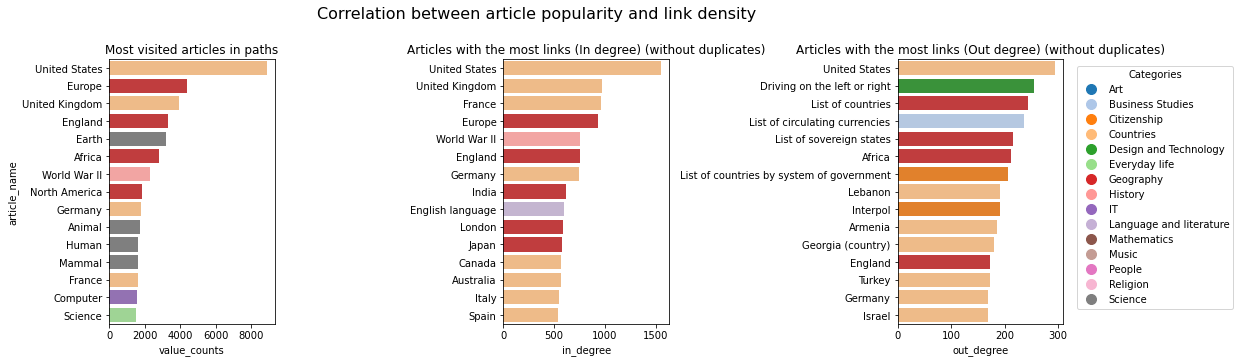

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

#Plot the most visited articles in finished paths
all_articles = []
df_finished['path'].apply(lambda x: all_articles.extend(x.split(';')))
df_path_articles = pd.Series(all_articles).value_counts().rename_axis('article_name').reset_index(name='value_counts')
df_path_articles["category"]=df_path_articles["article_name"].apply(lambda x: df_categories[df_categories["article"]==x]["level_1"].values[0] if len(df_categories[df_categories["article"]==x]["category"].values)>0 else "None")
df_path_articles = df_path_articles[df_path_articles['article_name'] != '<']

sn.barplot(x='value_counts', y='article_name', hue="category", palette=color_mapping, data=df_path_articles.head(15), ax=ax[0])
ax[0].set_title('Most visited articles in paths')
ax[0].legend_.remove() 

for i, metric in enumerate(["in_degree", "out_degree"]):
    sn.barplot(x=metric, y='article', hue="category", palette=color_mapping, data=df_article.sort_values(metric, ascending=False).head(15), ax=ax[i+1])
    ax[i+1].set_title(f'Articles with the most links ({metric.replace("_", " ").capitalize()}) (without duplicates)')
    ax[i+1].legend_.remove()
    ax[i+1].set_ylabel('')

add_legend_category(fig)
plt.suptitle("Correlation between article popularity and link density", y=1, fontsize=16)
plt.tight_layout()

Results : We observe a significant overlap between the most visited articles and those with the highest degree. Additionally, the "Countries" category is prominently represented.

## 3.2. Analyse user behaviour

Let's look for patterns in user behaviour and try to understand how we could measure whether a game was difficult or not. Many different metrics can be considered, for instance:
- Game duration
- Game path length
- Difficulty rating given for finished paths
- Number of back-clicks needed
- Whether a game was finished or not
- For unfinished games, how the game was abandoned

A combination of these parameters can help finding in which games users struggled. This will then allow to assess whether players struggle less in <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than in other paths.

Let's first have a look of how the difficulty measures are distributed amongst each other for finished paths.

### 3.2.a Path duration

The median duration of finished paths is 107 seconds
The median duration of all unfinished paths is 261 seconds, among which :
  - The median duration of restart paths is 114 seconds
  - The median duration of timeout paths is 1864 seconds
Kurtosis of finished game durations: 3972.65
Kurtosis of restart game durations: 45.47
Kurtosis of timeout game durations: 136.68


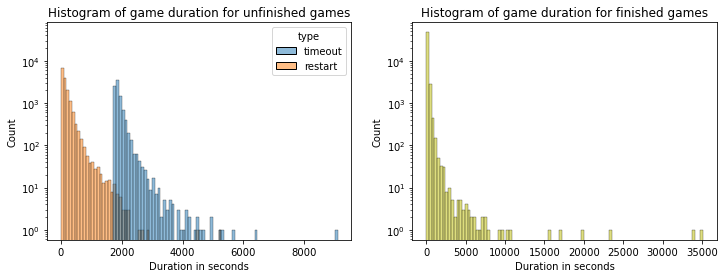

In [10]:
# Find medians and kurtosis for both finished and unfinished
median_finished = df_finished['durationInSec'].median()
kurtosis_finished = kurtosis(df_finished['durationInSec'])
median_unfinished = df_unfinished.groupby('type')['durationInSec'].median()
kurtosis_unfinished = df_unfinished.groupby('type')['durationInSec'].apply(kurtosis)

print(f"The median duration of finished paths is {median_finished:.0f} seconds")
print(f"The median duration of all unfinished paths is {df_unfinished['durationInSec'].median():.0f} seconds, among which :")
print(f"  - The median duration of restart paths is {median_unfinished['restart']:.0f} seconds")
print(f"  - The median duration of timeout paths is {median_unfinished['timeout']:.0f} seconds")

print(f"Kurtosis of finished game durations: {kurtosis_finished:.2f}")
print(f"Kurtosis of restart game durations: {kurtosis_unfinished['restart']:.2f}")
print(f"Kurtosis of timeout game durations: {kurtosis_unfinished['timeout']:.2f}")

# Plotting histograms
plt.figure(figsize=(12, 4))

# Unfinished games
ax1 = plt.subplot(121)
sn.histplot(df_unfinished, x='durationInSec', hue='type', bins=100)
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('Histogram of game duration for unfinished games')

# Finished games
plt.subplot(122, sharey=ax1)
sn.histplot(df_finished, x='durationInSec', bins=100, alpha=0.5, color='y')
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('Histogram of game duration for finished games')
plt.show()

Time-out paths are games where the player stopped playing for more that 30 minutes. If we set those aside, and look at the duration of paths where the players decided to restart a new game, the mediam duration of games is 114 seconds, approximately the same as finished path duration of 107 seconds.

The kurtosis in finished games is much higher than in unfinished restart games (3973 vs 45), meaning that finished games are more heavy tailed. We can in fact see very little players restart after 3000 seconds, whereas many finished games go beyond 6000. 

### 3.2.b Path duration and path length vs. user rating

Let's first look at path duration distribution over different user rating. We found similar results for finished and unfinished paths, so let's have a look at **finished ones** for example.

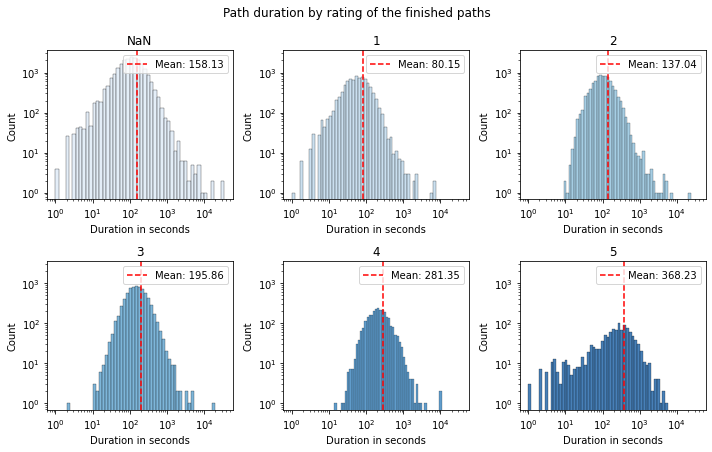

In [11]:
# change metric to 'path_length' for path length 
metric = 'durationInSec' 

df_finished_strNaN = df_finished.copy()
df_finished_strNaN['rating'] = df_finished_strNaN['rating'].fillna('NaN')

plt.figure(figsize=(10, 6))
blues_palette = sn.color_palette("Blues", n_colors=6)

means, stds = [], []
ax1 = plt.subplot(231)
sn.histplot(df_finished[df_finished_strNaN['rating']=='NaN'], x=metric, bins=50, log_scale=True, color=blues_palette[0]) 
mean = df_finished[df_finished_strNaN['rating']=='NaN'][metric].mean()
plt.axvline(mean, color='red', label=f'Mean: {mean:.2f}', linestyle='--')
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('NaN')
plt.legend()

for i in range(1, 6):
    plt.subplot(231+i, sharex = ax1, sharey=ax1)
    sn.histplot(df_finished[df_finished_strNaN['rating']==i], x=metric, bins=50, log_scale=True, color=blues_palette[i])
    mean = df_finished[df_finished_strNaN['rating']==i][metric].mean()
    plt.axvline(mean, color="red", label=f'Mean: {mean:.2f}', linestyle='--')
    plt.yscale('log')
    plt.title(i)
    plt.xlabel('Duration in seconds')
    plt.legend()

plt.tight_layout()
plt.suptitle('Path duration by rating of the finished paths', y=1.04)
plt.show()

The distributions of the path duration by rating are nice log-normal distributions! This means we can use the mean (location) and standard deviation (scale) to characterise them. Indeed, except for NaN, there is a steady increase of the path duration mean when rating goes up.

Let's now look at whether path duration is correlated with path length:

In [12]:
df_path_stats_duration = pd.DataFrame()
df_path_stats_duration['mean'] = df_finished.groupby('rating', dropna=False)['durationInSec'].mean()
df_path_stats_duration['std'] = df_finished.groupby('rating', dropna=False)['durationInSec'].std()
df_path_stats_duration['sem'] = df_finished.groupby('rating', dropna=False)['durationInSec'].sem()

df_path_stats_length = pd.DataFrame()
df_path_stats_length['mean'] = df_finished.groupby('rating', dropna=False)['path_length'].mean()
df_path_stats_length['std'] = df_finished.groupby('rating', dropna=False)['path_length'].std()
df_path_stats_length['sem'] = df_finished.groupby('rating', dropna=False)['path_length'].sem()

df_path_stats = pd.concat([df_path_stats_duration, df_path_stats_length], axis=1, keys=['duration', 'length'])

df_path_stats

duration                            length                     
              mean         std        sem       mean        std       sem
rating                                                                   
1.0      80.150609  152.273618   1.648539   4.664909   2.052327  0.022219
2.0     137.036683  311.602204   3.325851   5.996355   2.432872  0.025967
3.0     195.863962  296.518511   3.482914   7.640866   3.706646  0.043538
4.0     281.351095  359.639492   6.870559  10.079927   5.871245  0.112164
5.0     368.231304  463.405289  13.665076  13.237391  17.200507  0.507215
NaN     158.130412  430.645883   2.855092   6.818030   4.030492  0.026721

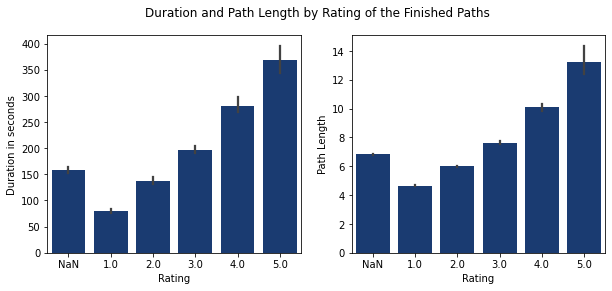

In [13]:
order = ['NaN', '1.0', '2.0', '3.0', '4.0', '5.0']

plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.barplot(df_finished_strNaN, x='rating', y='durationInSec', order=order, errorbar=('ci', 95), color='#0b3880')
plt.xlabel('Rating')
plt.ylabel('Duration in seconds')
plt.subplot(122)
sn.barplot(df_finished_strNaN, x='rating', y='path_length', order=order, errorbar=('ci', 95), color='#0b3880')
plt.suptitle('Duration and Path Length by Rating of the Finished Paths')
plt.xlabel('Rating')
plt.ylabel('Path Length')
plt.show()

There is a clear correlation between how long players took or how many clicks they made with the experienced difficulty rating. This means we can easily combine the two into a difficulty measure as they agree with each other on what players considered difficult. 

Let's now loow at back-clicks: could it indicate whether players had a hard time?

### 3.2.c Back-clicks
The number of back-clicks made in a game may indicate players getting stuck.
Lets investigate how this metric is related with player ratings, and if they are more prominent in certain categories:

In [14]:
# We will explain later (3.3) what filtering the most specific category really means
df_categories_filtered = filter_most_specific_category(df_categories)
paths_finished = extract_category_path(df_finished, df_categories_filtered)
paths_finished = backtrack(paths_finished)

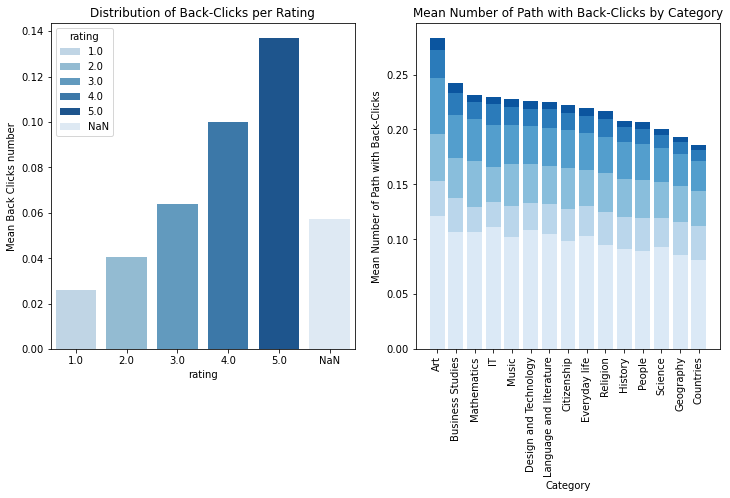

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

back_per_rating = paths_finished.groupby("rating", dropna=False).agg({"back_nb": "mean", "size": "mean"}).reset_index()
back_per_rating['Mean Back Clicks number'] = back_per_rating["back_nb"]/back_per_rating["size"]
back_per_rating['rating'] = back_per_rating['rating'].fillna('NaN')
sn.barplot(x="rating", y='Mean Back Clicks number', hue="rating", data=back_per_rating, palette=blues_palette[1:]+blues_palette[:1], ax=ax[0], legend=True)

df_exploded = paths_finished.explode('category')
category_back_mean = df_exploded.groupby(['category', 'rating'], dropna = False).size().reset_index(name='size')
back_mean = df_exploded.groupby('category')["have_back"].mean().reset_index().sort_values(by='have_back', ascending=False)
category_back_mean = category_back_mean.merge(back_mean, on='category').sort_values(by='have_back', ascending=False)
category_back_mean['rating_proportion'] = category_back_mean.groupby('category')['size'].transform(lambda x: x / x.sum())

order = category_back_mean["category"].unique()
base_heights = category_back_mean[['category', 'have_back']].drop_duplicates().set_index('category')['have_back']
df_pivot = category_back_mean.pivot(index='category', columns='rating', values='rating_proportion').fillna(0)
df_pivot = df_pivot.reindex(order)


bottom = pd.Series([0] * len(df_pivot), index=df_pivot.index)
for i, rating in enumerate(df_pivot.columns):
    ax[1].bar(df_pivot.index, 
           height=df_pivot[rating] * base_heights,  
           bottom=bottom * base_heights,           
           label=f'Rating {rating}', 
           color=blues_palette[i])
    bottom += df_pivot[rating]

ax[1].set_title('Mean Number of Path with Back-Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Mean Number of Path with Back-Clicks')
plt.xticks(rotation=90)
ax[0].set_title("Distribution of Back-Clicks per Rating")
plt.show()

The back-clicks are correlated with the difficulty rating, which is expected as the more difficult a game is, the more likely players are to get stuck and go back.
The category with the most back-clicks is "Art", and the one with the least is "Countries". This is interesting as "Countries" is also one of the most visited category, which might indicate that players are more familiar with it and therefore less likely to get stuck.
Additionaly, The distribution of rating inside each category seams quite similar.

## 3.3 Look at articles as a categories types

### 3.3.a Categories Distributions
! Interactive plots with plotly need the notebook to be run but were replaced with screenshots for convenience. !

In [ ]:
labels, parents, values, ids = create_treemap_data(df_categories)
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
    textfont=dict(size=18),
))
fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles Counting Every Category for Each Article")
fig.show()

![alt text](./figures/33a.png)


In [17]:
print(f'We have {df_categories["level_1"].unique().size} distinct level 1 categories.')

We have 15 distinct level 1 categories.


- Each category is organized into multiple sub-levels, with a hierarchical depth of up to 3 levels.

- For this analysis, we will focus exclusively on the most superficial level: Level 1.

- Additionally, we observe that some articles are associated with multiple categories, highlighting overlaps and shared connections within the dataset.

#### Articles with Multiples Categories

- First we count the numbers of articles with multiples categories:

In [18]:
# Count the number of articles with multiples categories
df_categories.groupby("article")["article"].size().value_counts()

article
1    3999
2     590
3       8
Name: count, dtype: int64

- But if we constrain it only to different type of level 1 categories, it is reduced to :

In [19]:
# Count the number of unique level 1 categories per article
df_categories.groupby("article")["level_1"].nunique().value_counts()

level_1
1    4091
2     505
3       1
Name: count, dtype: int64

In [20]:
category_abbreviations = {
    'Art': 'Art',
    'Mathematics': 'Math',
    'IT': 'IT',
    'Business Studies': 'BS',
    'Music': 'Music',
    'Religion': 'R',
    'Language and literature': 'L&L',
    'Citizenship': 'CIT',
    'Countries': 'C',
    'Design and Technology': 'D&T',
    'Everyday life': 'Life',
    'History': 'Hist',
    'People': 'P',
    'Geography': 'Geo',
    'Science': 'Sci'
}

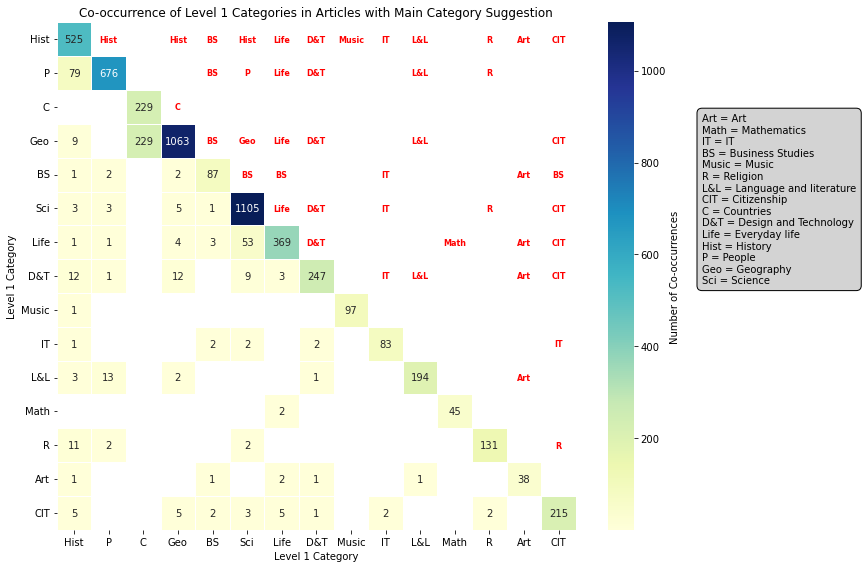

In [21]:
plot_cooccurrence_cat_matrix(df_categories, category_abbreviations)

Attributing the **main category** to articles with multiple categories based on the category **with fewer total articles** helps prioritize specialization over generality. 

Categories with fewer total articles are typically more specific, while those with higher counts cover broader topics. By focusing on the category with fewer articles, we ensure the article’s primary focus is on a unique or specialized perspective, providing a clearer thematic assignment. This method promotes a balanced classification system, ensuring articles are categorized accurately without being overshadowed by more general categories.

- For example, a category like **"Geography"** may encompass a wide range of topics, while **"Countries"** might be more specialized.

In [ ]:
df_categories_filtered = filter_most_specific_category(df_categories)

labels_filtered, parents_filtered, values_filtered, ids_filtered = create_treemap_data(df_categories_filtered)
fig = go.Figure(go.Treemap(
    labels=labels_filtered,
    parents=parents_filtered,
    values=values_filtered,
    ids=ids_filtered,
    textfont=dict(size=18),
))

fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles (Only the most specific category is shown for each article)")
fig.show()

![alt text](./figures/33a1.png)

### 3.3.b Transitions between categories

We decide to merge the finished and unfinished paths as in this section we will first only analyse how users make moves between categories of articles, independ of their succes on the research.

In [23]:
paths_merged = pd.concat([df_finished, df_unfinished])
common_paths = analyze_categories_paths(paths_merged, df_categories_filtered, omit_loops=False)

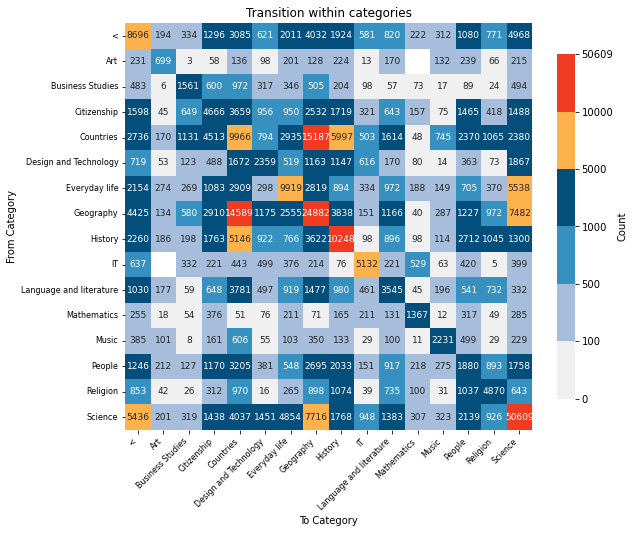

In [24]:
matrix_f = matrix_common_paths(common_paths)
transition_cat_matrix(matrix_f)

While this is not the best way to visualise transitions between categories (this comes a bit later with graphs), it gives some important numerical values as first overview. Certain transitions seem to be more prominent than others, such as transitions from Geography to Countries or clicks to remain in Science. Generally, a lot of paths lead to Countries and Geography. Back-clicks, History and Science also have an overall strong presence. Does this give any real information about transitions users like or is it simply due to how many articles there are for the analysed categories?

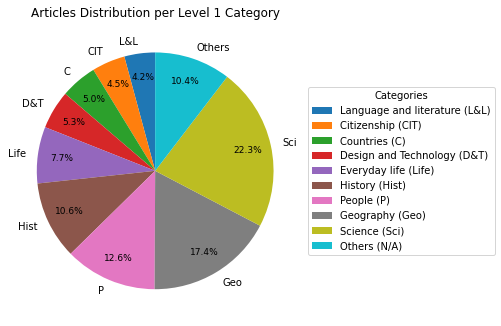

In [25]:
plot_articles_pie_chart(df_categories_filtered, category_abbreviations)

Geography is both a category that many articles have and a category with high transitions. This needs to be further analysed to see if users really choose to go through Geography or if they are just more likely to find an article with that category. The same cannot be said for Countries, which is a much smaller category which still has high transition counts!

#### Transitions within categories (including self-category)

Example :
- Science -> Science -> Science
- Science -> Science -> Science -> Citizenship -> Design and Technology

In [ ]:
df_position_data = get_position_frequencies(common_paths, max_position=15)
plot_position_line(df_position_data, df_article, title="Position Frequencies for Finished Paths")

![alt text](./figures/33a2.png)

#### Transitions within categories (excluding self-category)

Let's remove the transitions in early articles that stay in the same category: if a player wants to leave a category but does not find an adequate link, we will only consider the next different category as next step.

For example :
- Science -> Science -> Science **becomes** Science
- Science -> Science -> Science -> Citizenship -> Design and Technology **becomes** Science -> Citizenship -> Design and Technology

In [27]:
common_paths_nl = analyze_categories_paths(paths_merged, df_categories_filtered, omit_loops=True)

In [ ]:
df_position_data = get_position_frequencies(common_paths_nl, max_position=15)
plot_position_line(df_position_data, df_article, title="Position Frequencies for Finished Paths")

![alt text](./figures/33a3.png)

We can see that the categories in the early path positions are very often Countries or Geography. A lot of paths start in Science, but players seem to either leave in the first steps or stay there for the rest of the path. Very few start in Countries, but this category seems to be the most popular one to go to as a second step. For Geography, the trend is less clear but players still rather join the category than leave it in the second step.

One last interesting analysis is that back-clicks seem to gain popularity as the paths get longer!

#### Transitions within categories of the optimal paths

We can analyze whether users’ choice of categories at each position aligns with the categories in the optimal path to determine if passing through 'country' or 'geography' early in the path is an effective strategy for reaching the target. To achieve this, we first need to compute the optimal path by constructing a directed graph where edges represent connections between articles.

In [29]:
optimal_paths = find_all_source_target_pairs(df_finished, df_unfinished, df_links)
optimal_paths = calculate_optimal_path(df_links, optimal_paths, df_shortest_path)

All computed path lengths match the expected lengths.


In [ ]:
opt_paths = analyze_categories_paths(optimal_paths, df_categories_filtered, users=False, omit_loops=False)
df_position_opt_data = get_position_frequencies(opt_paths, max_position=15)
plot_position_line(df_position_opt_data, df_article, title="Position Frequencies for Optimal Paths")

![alt text](./figures/33a4.png)

Indeed, <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> seem to often be the ideal algorithmic path. This is interesting, but in the future we will need to also compare <i>human</i> best performance with the voyages to draw a conclusion.

### 3.3.c Networks

Here, we create a network *(directed graph)* to represent user transitions between different categories of articles.

- **Nodes:** Each node represents a group of articles belonging to a specific category, with each article assigned to his main category. 
- **Edges:** Each edge represents a transition from one article category to another, indicating the flow of user activity.

In this visualization, we exclude transitions within the same category (self-loops), as these are already represented in the transition matrix shown earlier (3.3.b). The focus here is on how users navigate between different categories.

The node positions are determined using a **force-directed algorithm**:

- Nodes repel each other like charged particles, preventing overlaps.
- Edges act like springs, pulling connected nodes closer to reflect their relationships.

----------


In the cell below, we recursively replace each back click **(<)** with the article that was visited prior to it. This ensures that we accurately reconstruct the original navigation path and correctly identify the corresponding category for each step.

In [31]:
paths_merged_with_replace_back = paths_merged['path'].apply(replace_back_clicks)

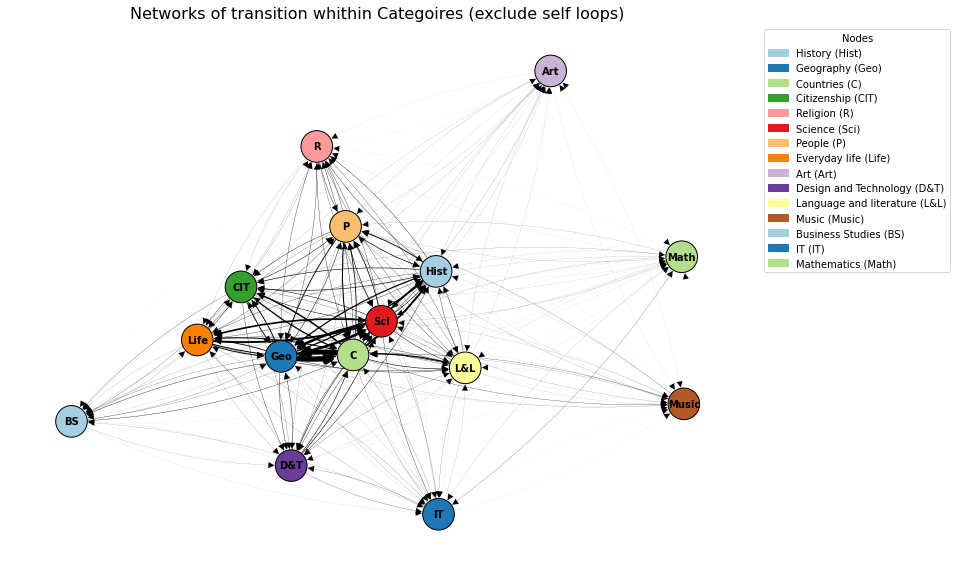

In [32]:
G = build_network(paths_merged_with_replace_back, df_categories_filtered, include_self_loops=False)

plot_network(G, title="Networks of transition whithin Categoires (exclude self loops)", show_edge_labels=False, node_size=1000, node_abbreviations=category_abbreviations)

We observe a clustered graph, with central clusters dominated by categories containing the largest number of articles, such as Science, Geography, People, and History. Additionally, we see Countries positioned close to the center,despite the small size of the category (only 5% of the total articles) reflecting its strong connections with these major categories.

Next, we will normalize the edge weights by the total number of articles in the **source** category. This adjustment accounts for the imbalance in category sizes, ensuring a more accurate representation of transition dynamics.

**Note:** Currently, we are normalizing by the size of the source node only. However, for future analyses, we plan to explore other normalization methods, such as accounting for the size of the target category.

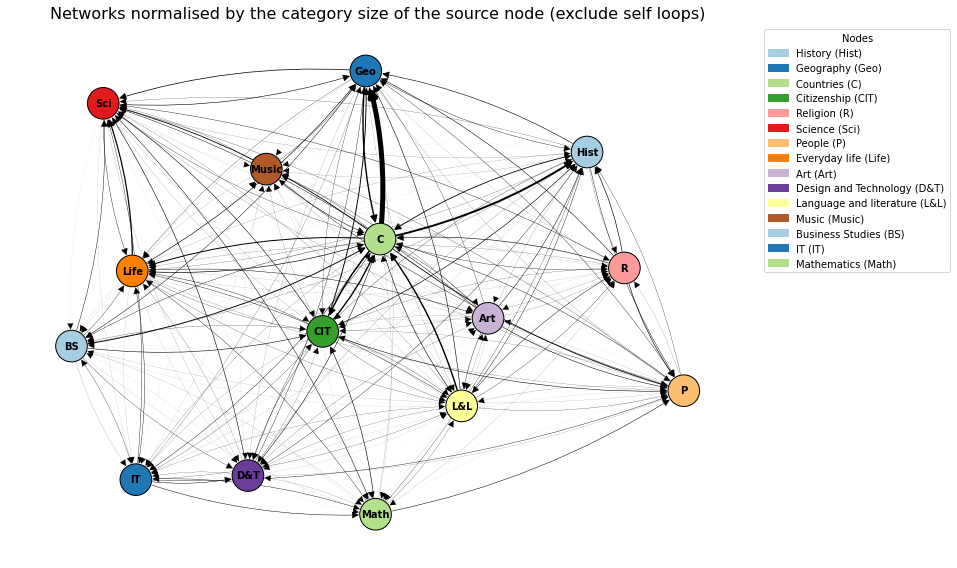

In [33]:
G_normalized = normalize_edge_weights(G, df_categories_filtered)
plot_network(G_normalized, title="Networks normalised by the category size of the source node (exclude self loops)", show_edge_labels=False, node_size=1000, node_abbreviations=category_abbreviations)

After normalizing, we clearly observe that **Countries** becomes even more central in the graph, while the other categories spread out further, forming less distinct clusters.

We also notice a particularly strong connection from Countries to Geography, which may be influenced by the fact that the current normalization only considers the size of the source category, not the target category.
And the inherent logical relationship between Countries and Geography.

- For future work, we aim to analyze the weights of each connection in greater detail to better understand these interdependencies and explore alternative normalization methods to capture the full dynamics of category relationships.

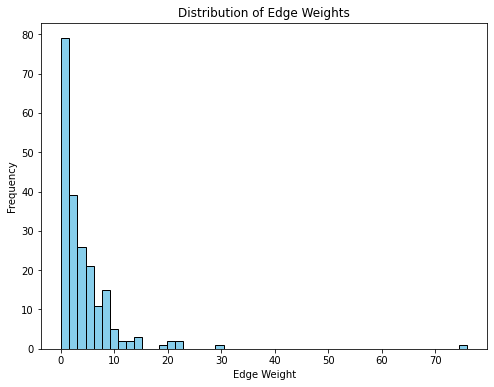

,Edge Weight Statistics
Count,210.000000
Mean,4.275123
Median,2.431531
Standard Deviation,6.708277
Min,0.036145
Max,75.982533
25th Percentile,0.820169
75th Percentile,5.722344


In [34]:
analyze_edge_weights(G_normalized)

## 3.4 Correlations and combination between previous results

### 3.4.a Corelation between difficulty and combination of source-target categories

Let's get a glance at the extend to which the choice of the source article and the end article affects the difficulty of the game.
This could highlight potential combinations of categories that are harder to connect.

Different difficulty metrics are used like path duration, path length in terms of number of clicks and user ratings. 

The number of back-clicks and its link with current difficulty mettrics and categories is also studied to explore whether it indicates difficulty as well.
#### Correlation between the duration of game and the combination of source-target category
Here the difficulty measure is the game duration.

In [35]:
paths_finished = find_categories_start_end(df_finished, df_categories_filtered)
paths_unfinished = find_categories_start_end(df_unfinished, df_categories_filtered)

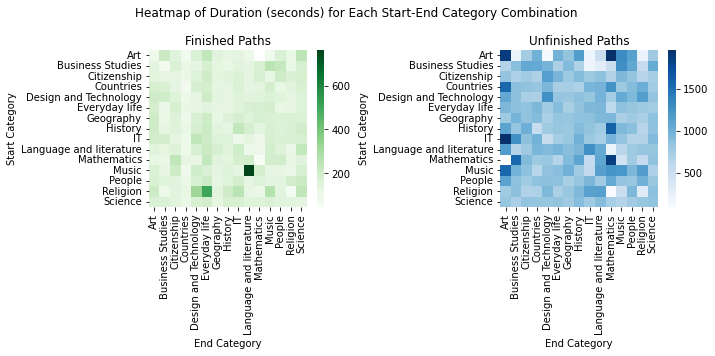

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='durationInSec', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='durationInSec',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='Greens', ax=ax[0])
ax[0].set_ylabel("Start Category")
ax[0].set_xlabel("End Category")

sn.heatmap(path_unfinished_length_categories , cmap='Blues', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of Duration (seconds) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

Linking a music article to a language and litterature article is the combination that takes the longest time (≈800s) to connect in finished paths. In unfinished paths, it takes ≈1300s, maybe indicating players tend to abandon due to difficulty? 

Curiously, connnecting art to mathematics is either very fast (<100s) in succesfull games, or takes a very long time (≈2000s) in unsuccesfull ones, this is also observed in connecting mathematics to mathematics for example.

In the other hand, connecting religion to religion takes a short time both in succesfull and unsuccesfull games. A short finished path might indicate easily connectable categories, whereas short unfinished paths could indicate early abandonment. Why would easilly conectable source and target lead to early abandonment for other players? Maybe this scenario can divide into two : either the target is directly on the source page or just a few clicks away, either they are not so close (for example linked to different religions), the density of links in the page might be low and the player might lack knowledge in the field. These potential causes will be analize in further parts.

#### Correlation between the length of path and the combination of source-target category
Here the difficulty metric used is the number of clicks in the game.

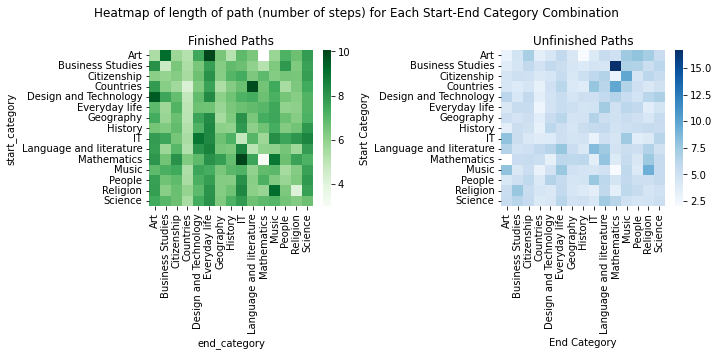

In [37]:
paths_finished["steps_count"] = paths_finished["path"].apply(lambda x: len(x.split(";")))
paths_unfinished["steps_count"] = paths_unfinished["path"].apply(lambda x: len(x.split(";")))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='steps_count', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='steps_count',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='Greens', ax=ax[0])
sn.heatmap(path_unfinished_length_categories , cmap='Blues', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of length of path (number of steps) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

#### Correlation between the player rating and the combination of source-target category
Here we use the difficulty rating by the players as difficulty metric.

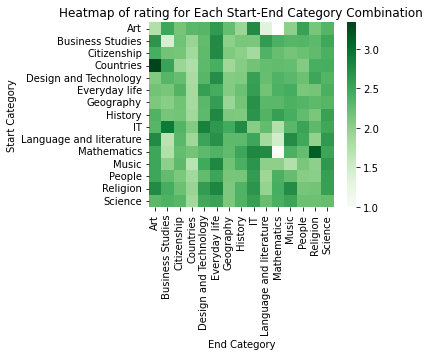

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='rating', 
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='Greens', square=True)
plt.title("Heatmap of rating for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

Some category combinations seem to be harder than others: Countries to Art of Mathematics to Religion seem to pose problems to players, while paths inside a category (the diagonal) seem to be generally perceived as easier.

# 4. Methods for Further Analysis
This section aims to show a few of the tools that will be useful along the way for our project. Instead of using them to answer our final question, we use them on the dataset as a whole to show that interesting information can be extracted from these methods.

## 4.1. Similarity on paths

Let's first get an intuition of how shortest paths are distributed and how articles are generally connected. The shortest path ranges from 1 to 9 if it exists, but it may also not exist at all (value -1). This means there are clusters of articles that are not linked to each other in the network. We can visualise this with a matrix that shows whether certain source and target articles are connected or not.

Total pairs: 21132409
Reachable pairs: 18579594
Unreachable pairs: 2548218
Sparsity percentage: 12.08%


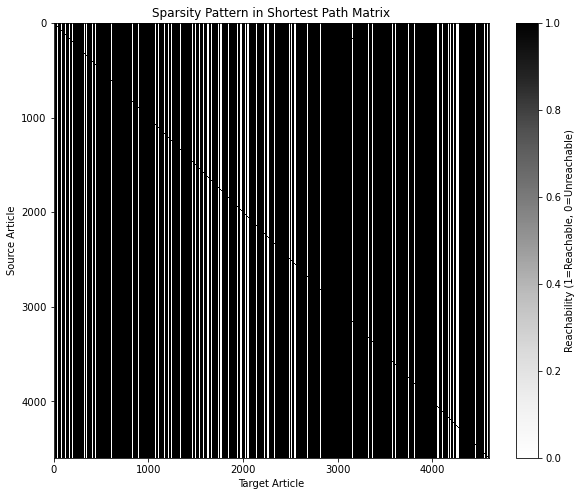

In [39]:
plot_shortest_paths_matrix(df_shortest_path)

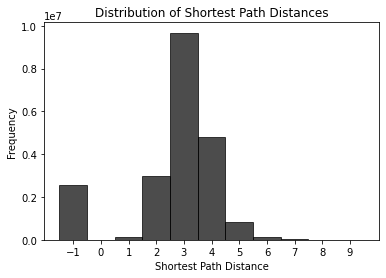

In [40]:
plt.figure(figsize=(6, 4))
plt.hist(df_shortest_path.values.flatten(), bins=np.arange(-1,11,1) - 0.5, alpha=0.7, edgecolor='black', color='black')
plt.xlabel('Shortest Path Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path Distances')
plt.xticks(np.arange(-1,10,1))
plt.show()

### 4.1.a Semantic Similarity

An interesting way to figure out how players move through the wikispeedia network is semantic similarity. This encompasses both categories similarity and the abstract notion of "meaning". To concretise this notion, we consider two different measures of similarity:
- semantic similarity based on article names embeddings
- semantic similarity based on the Jaccard similarity of categories (with stronger weights for more specific categories)

An interesting application is finding clusters of words that are more similar to each other than to words in other clusters. The clustering allows to reorder the similarity matrix in a way that regroups articles with high (or low) similarity.

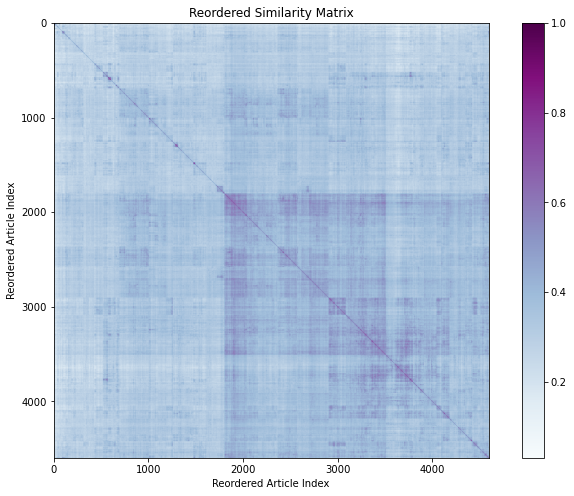

In [41]:
# Perform hierarchical clustering
sm = df_sm.to_numpy()
linkage_matrix = linkage(sm, method='ward')
ordered_indices = leaves_list(linkage_matrix)
reordered_matrix = sm[ordered_indices, :][:, ordered_indices]

plt.figure(figsize=(12, 8))
plt.imshow(reordered_matrix, cmap='BuPu')
plt.title('Reordered Similarity Matrix')
plt.xlabel('Reordered Article Index')
plt.ylabel('Reordered Article Index')
plt.colorbar()
plt.show()

In [ ]:
# Define the initial threshold
initial_threshold = 0.5

# Function to plot the binary matrix based on a given threshold
def plot_thresholded_matrix(threshold):
    # Create a binary mask with the current threshold
    binary_matrix = np.where(reordered_matrix >= threshold, 1, 0)
    
    # Plot the binary matrix
    plt.figure(figsize=(12, 8))
    plt.imshow(binary_matrix, cmap='Reds', interpolation='nearest')
    plt.title(f'Reordered Similarity Matrix (Threshold = {threshold:.2f})')
    plt.xlabel('Reordered Article Index')
    plt.ylabel('Reordered Article Index')
    plt.colorbar(label='Above Threshold (1 = Red, 0 = White)')
    plt.show()

# Create the interactive slider
threshold_slider = widgets.FloatSlider(
    value=initial_threshold,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Threshold:',
    continuous_update=False
)

# Display the slider and link it to the plotting function
output = widgets.interactive_output(plot_thresholded_matrix, {'threshold': threshold_slider})
display(threshold_slider, output)

![alt text](./figures/41a.png)

We can clearly see that the reordered article indices make intuitive sense, similar words are regrouped. Words in the clusters with high similarity (similarity > 0.5) are words that appear more often in natural language, while words in the low-similarity areas are similar one to another, but not commonly used. This shows that we can regroup articles in clusters of 'well-known words' that are likely more present on user paths.

In [ ]:
print(f'Words in high similarity clusters are for example {", ".join(df_article_names[ordered_indices].iloc[1995:2005].tolist())}')
print(f'Words in low similarity clusters are for example {", ".join(df_article_names[ordered_indices].iloc[-7:].tolist())}')

Words in high similarity clusters are for example Humour, Logic, Radio, Radio frequency, Radar, Recorder, Dance, Rapping, Rain, Sound
Words in high similarity clusters are for example Ancient history, Greek mythology, Mythology, History of Earth, History of the world, History, Modern history


### 4.1.b Correlation between source-target similarity, and shortest possible path length
Similar articles should be easier to connect, let's verify this using shortest possible path length as a difficulty measure.

We will look at article's semantic symilarity using cosine similarity, and article's category similarity. Pearson and Spearman correlations will then be used to asses how significant these difficulty measures are.

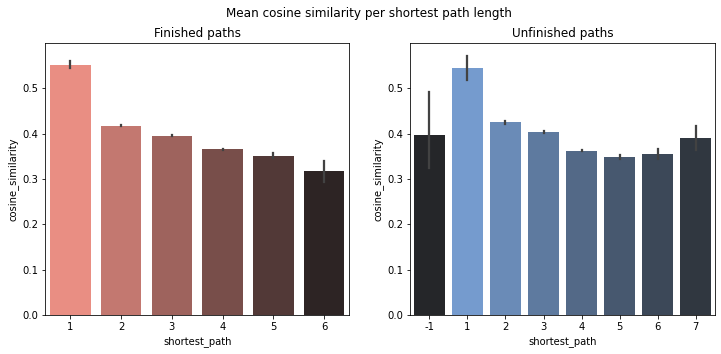

In [44]:
reds_palette = sn.dark_palette("salmon", n_colors=len(df_finished['shortest_path'].unique()), reverse=True)
blues_palette = sn.dark_palette("#69d", n_colors=len(df_unfinished['shortest_path'].unique()), reverse=True)
blues_palette = [blues_palette[-1]] + blues_palette[:-1] # put impossible paths in evidence

plt.figure(figsize=(12, 5))

# Finished paths plot
ax = plt.subplot(121)
sn.barplot(data=df_finished, x='shortest_path', y='cosine_similarity', hue='shortest_path', legend=None, palette=reds_palette)
plt.title('Finished paths')

# Unfinished paths plot
plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='cosine_similarity', hue='shortest_path', legend=None, palette=blues_palette)
plt.title('Unfinished paths')

plt.suptitle('Mean cosine similarity per shortest path length')
plt.show()

In [45]:
from scipy.stats import pearsonr, spearmanr

def calculate_correlations_with_shortestPath(df, column_name):
    # Ensure 'shortest_path' is numeric
    df['shortest_path'] = df['shortest_path'].astype(float)

    pearson_corr, pearson_p = pearsonr(df['shortest_path'], df[column_name])
    spearman_corr, spearman_p = spearmanr(df['shortest_path'], df[column_name])

    # Print results
    print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")
    print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4e}")

print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished,"cosine_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"cosine_similarity")

Finished paths:
Pearson correlation: -0.2837, p-value: 0.0000e+00
Spearman correlation: -0.2359, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.2732, p-value: 0.0000e+00
Spearman correlation: -0.2751, p-value: 0.0000e+00


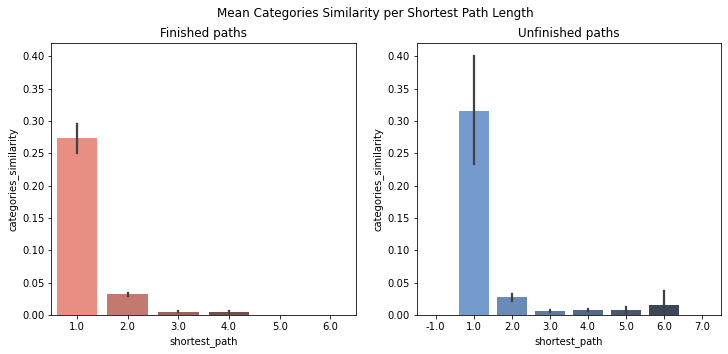

In [46]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished, x='shortest_path', y='categories_similarity', hue='shortest_path', legend=None, palette=reds_palette)
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='categories_similarity', hue='shortest_path', legend=None, palette=blues_palette)
plt.title('Unfinished paths')

plt.suptitle('Mean Categories Similarity per Shortest Path Length')
plt.show()

In [47]:
print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished,"categories_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"categories_similarity")

Finished paths:
Pearson correlation: -0.1968, p-value: 0.0000e+00
Spearman correlation: -0.1938, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.0763, p-value: 3.3577e-33
Spearman correlation: -0.0816, p-value: 8.2011e-38


The **Pearson correlation** measures the linear relationship between two continuous variables. And the **Spearman correlation** assesses the monotonic relationship using ranked data, making it less sensitive to outliers and non-linear relationships.


The article semantic similarity, and category similarity of finished paths have **moderate negative correlation** with path length (≈-0.25), and the category similarity of unfinished paths has weak negative correlation (≈-0.2).

Both for articles and category similarity, the **p-values are zero**, showing high statistical significance. The observed correlations are thus unlikely to be due to random chance.

Negative correlation indicates that as the minimal possible path length increases, the cosine similarity decreases.
In other words, when the source and targets articles are close semantically, and their categories similar, the shortest possible path shrinkens, which makes sense as is it easier to connect 2 very similar articles.

## 4.2. Evolution of similarity on paths
Now that we established similarity as a metric, can we see how mean similarity evolves on paths in general? Do we observe that users quickly try to leave a category in the first few clicks? Later this will be used to assess whether there is a difference for voyages and non-voyages, and whether there is a difference depending on the categories the path in made of, but for now this already gives an insight into what we can expect.

In [48]:
all_finished_paths = [replace_back_clicks(path).split(';') for path in df_finished['path'].tolist()]
path_similarities = []

for path in all_finished_paths:
    path_similarity = []
    for step in range(len(path)-1):
        current, next = path[step], path[step+1]
        path_similarity.append(df_sm[current][next])

    path_similarities.append(path_similarity)

Here is an example to understand what is going on. Each point represents a click of a user, to go from the first page (Batman) to the next (Chemistry). Batman and Chemistry are not strongly semantically related (hence the relatively low value of about 0.4). In the next step to Biology, the similarity is much higher (about 0.7), so the player first leave the category to reach the target category and then tends to stay there.

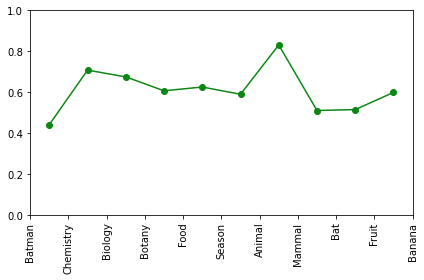

In [49]:
path_id = 1829
path = path_similarities[path_id]
plt.plot(range(len(path)), path, marker='o', color='#0c8714')
plt.xticks([i-0.5 for i in range(len(path)+1)], all_finished_paths[path_id], rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [50]:
len_N_path_similarity = {}
for path_sim in path_similarities:
    path_length = len(path_sim)
    len_N_path_similarity.setdefault(path_length, []).append(path_sim)

len_N_mean_similarity = {paths_len: np.mean(paths, axis=0) for paths_len, paths in len_N_path_similarity.items()}

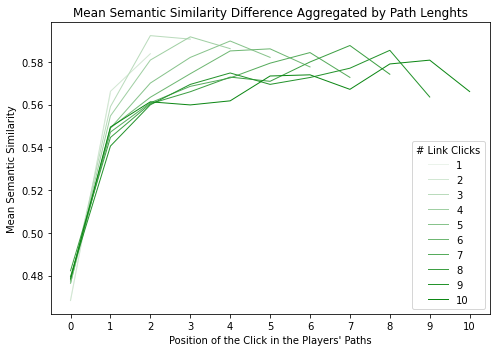

In [51]:
plt.figure(figsize=(7, 5))
greens_palette = sn.light_palette("#0c8714", n_colors=10)

for i in range(1, 11):
    sn.lineplot(len_N_mean_similarity[i+1], lw=1, label=i, color=greens_palette[i-1])
plt.legend(title='# Link Clicks')
plt.xlabel("Position of the Click in the Players' Paths")
plt.xticks(range(0, 11))
plt.ylabel('Mean Semantic Similarity')
plt.title('Mean Semantic Similarity Difference Aggregated by Path Lenghts')
plt.tight_layout()
plt.show()

There is a clear trend: in the first few clicks, the articles chosen have a low similarity to the previous one: this can be interpreted as leaving the original category. After this, the similarity for the next clicks stabilises, with only small fluctuations.

# 5. Find Voyages

A considerable number of users go through countries or articles about geography to find their target, irrespective of the categories of the initial and target articles: let’s call this the <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span>, and define it:

Lets define a _Wikispeedia Voyage_ as a game in which the source is not in the categories Countries nor Geography, and that passes through articles in either those categories.

### Sort games into voyage or not-voyage 

In [52]:
# sort paths into voyage and non-voyage
df_finished_voyage = game_voyage_sorting(df_finished, df_categories, True, n=3)
df_unfinished_voyage = game_voyage_sorting(df_unfinished, df_categories, False, n=3)

# count the voyages 
voyage_count = (df_finished_voyage['voyage'] == 1).sum() + (df_unfinished_voyage['voyage'] == 1).sum()
non_voyage_count = (df_finished_voyage['voyage'] == 0).sum() + (df_unfinished_voyage['voyage'] == 0).sum()

print('Out of the ', len(df_finished_voyage)+len(df_unfinished_voyage), ' finished and unfinished games : ')
print('  - ', voyage_count, ' are voyages')
print('  - ', non_voyage_count, ' are not')

Out of the  75913  finished and unfinished games : 
  -  32619  are voyages
  -  43294  are not


In [ ]:
#concatenate all games in a dataframe and plot the sankey diagram 
df_all_voyage = pd.concat([df_finished_voyage, df_unfinished_voyage], ignore_index=True, sort=False)
plot_sankey_voyage(df_all_voyage)

![alt text](./figures/5.png)

# 6. Analyse voyages
### ➜ This is our milestone P3!

Compare <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> with the other paths on the basis of experienced difficulty and performance.

In [6]:
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Christmas', 'Fats', 'Charlottes web', 'Bogota', 'Sportacus', ' Zebra', 'Rat', 'Podcast', 'Rss', 'Usa', 'Great', 'Mustard', 'Kashmir', 'Long peper', 'Western Australia', 'The', 'Test', 'The Rock', 'Netbook', 'English', 'Macedonia', 'Adolph Hitler', 'Black ops 2', 'Pikachu', 'Georgia'}
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24714 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of rows after filtering: 51199


In [20]:
df_finished_voyage = game_voyage_sorting(df_finished, df_categories, True, n=3)
df_unfinished_voyage = game_voyage_sorting(df_unfinished, df_categories, False, n=3)

In [21]:
df_all_voyage = pd.concat([df_finished_voyage, df_unfinished_voyage], ignore_index=True, sort=False)
plot_sankey_voyage(df_all_voyage)

### TODOs
1. **INTRO**: On the top of the website, it is probably a good idea to be catchy and start with the Voyage vs Non-Voyage plot first (it gives a good but not too complex introduction). Then we can get over to justifications of the project choice and details
2. **INTRODUCTORY STATS**: Be smart about figures, we really don't want too many here!
   1. Have a statistic like the correlation between article popularity and link density (3.1.c) to highlight why Countries and Geography generally make sense to travel through as a motivation (slightly change the plot to make it more obvious and suitable for website). 
   2. As a second motivation, put the graph with Countries in the middle (and/or any other stats about categories in particular *if needed*, to show their prevalence in paths or in the dataset).
   3. Then, a summary plot for the difficulty would probably be smart as it will be used in the main results.
3. **CORE RESULTS**: for Voyage vs Non-Voyage, only keep the visuals for interesting results but mention the unsignificant ones. If we find nothing at first, we can look further into how to define Voyage vs Non-Voyage more precisely (e.g. only keeping Countries).
   1. Article features (3.1.a) for the two classes
   2. Difficulty measures (3.2), comparing path efficiencies in both classes. Do people in voyages succeed more for similar games? + comparing with shortest paths
   3. Have some idea *when* people do voyages (and when they do not). Is it in difficult games? Any games? (difficulty based on start and end categories 3.4).
   4. Similarity on paths, semantic detour
   5. (Something causal about human reasoning if we find anything)
4. Some conclusion + introducing further research ideas
